#Distance Estimator
To estimate the real distance(unit: meter) of the object

__Input__: Bounding box coordinates(xmin, ymin, xmax, ymax)   
__Output__: 3D location z of carmera coordinates(z_loc)

## Load Module

In [1]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
import torch
import category_encoders as ce
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
os.makedirs('./weights', exist_ok=True)

## Dataset

In [3]:
df_train = pd.read_csv('../datasets/kitti_train.csv')
df_valid = pd.read_csv('../datasets/kitti_valid.csv')
df_test = pd.read_csv('../datasets/kitti_test.csv')

In [4]:
df_train['class'].unique()

array(['person', 'car', 'truck', 'train', 'bicycle', 'Misc'], dtype=object)

In [5]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [6]:
# Ordinal Encoding
#encoder= ce.OrdinalEncoder(cols=['Degree'],return_df=True,
#                           mapping=[{'col':'class', 
#                                'mapping':{'Misc':0, 'person':1, 'bicycle':2, 'car':3, 'train':4, 'truck': 4}}])
#df_train = encoder.fit_transform(df_train)
#df_valid = encoder.fit_transform(df_valid)
#df_test = encoder.fit_transform(df_test)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22022 entries, 0 to 22021
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    22022 non-null  object 
 1   class       22022 non-null  object 
 2   xmin        22022 non-null  float64
 3   ymin        22022 non-null  float64
 4   xmax        22022 non-null  float64
 5   ymax        22022 non-null  float64
 6   angle       22022 non-null  float64
 7   zloc        22022 non-null  float64
 8   weather     22022 non-null  object 
 9   depth_y     22022 non-null  int64  
 10  depth_mean  22022 non-null  float64
 11  depth_x     22022 non-null  int64  
 12  depth_min   22022 non-null  float64
 13  width       22022 non-null  float64
 14  height      22022 non-null  float64
 15  Misc        22022 non-null  uint8  
 16  bicycle     22022 non-null  uint8  
 17  car         22022 non-null  uint8  
 18  person      22022 non-null  uint8  
 19  train       22022 non-nul

In [8]:
variable = ['xmin','ymin','xmax','ymax','width', 'height','depth_min','depth_mean', 'Misc', 'bicycle','car','person','train','truck']
val_length = len(variable)
batch_sz = 48 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train
train_dataset = CustomDataset(df_train, variable, scaler=True, train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
# train_sclaer
scaler_train = train_dataset.scaler

# valid
valid_dataset = CustomDataset(df_valid, variable, True, train=scaler_train)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, shuffle=True)

# train
test_dataset = CustomDataset(df_test, variable, True, train=scaler_train)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(df_test), shuffle=False)

In [9]:
val_length # 14

14

In [10]:
# look dataset
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    print(batch[0])
    print(batch[0].shape)
    print(batch[1])

tensor([[-1.8812e+00,  7.0806e-01, -1.9596e+00, -2.4911e-01, -2.0734e-01,
         -5.5150e-01,  1.4939e-01,  1.5609e-02, -8.0560e-02, -7.4329e-02,
          4.4485e-01, -3.7963e-01, -8.0274e-02, -1.4606e-01],
        [-7.0772e-01,  5.5088e-02, -6.8562e-01, -3.0127e-01,  8.3128e-02,
         -3.3858e-01, -4.7969e-01, -2.3809e-01, -8.0560e-02, -7.4329e-02,
          4.4485e-01, -3.7963e-01, -8.0274e-02, -1.4606e-01],
        [-2.5421e-01,  9.4120e-02, -5.4476e-01, -8.9646e-01, -9.0215e-01,
         -9.7889e-01,  1.0326e+00,  7.3955e-01, -8.0560e-02, -7.4329e-02,
          4.4485e-01, -3.7963e-01, -8.0274e-02, -1.4606e-01],
        [ 6.3357e-01, -1.7908e-01,  4.3778e-01, -5.1056e-01, -6.2396e-01,
         -4.6214e-01, -1.4027e-01,  1.9811e-01, -8.0560e-02, -7.4329e-02,
          4.4485e-01, -3.7963e-01, -8.0274e-02, -1.4606e-01],
        [ 1.7852e+00, -1.2054e+00,  2.3800e+00,  2.3992e+00,  1.8217e+00,
          3.0106e+00, -1.1396e+00, -1.3239e+00, -8.0560e-02, -7.4329e-02,
          4.

## Modeling

In [11]:
class Zloc_Estimaotor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim=1):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=False)
        
        #Layer
        layersize=[256, 128, 64, 32]
        layerlist= []
        n_in=hidden_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.Hardswish())
            #layerlist.append(nn.BatchNorm1d(i))
            #layerlist.append(nn.Dropout(0.2))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        #layerlist.append(nn.Sigmoid())
        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        out, hn = self.rnn(x)
        output = self.fc(out[:,-1])
        return output

## Make  variable

In [12]:
import torch.nn.init as init
#def weight_init(m):
#    if isinstance(m, nn.Linear): # nn.Linear에 있는 가중치에만 적용
#        init.kaiming_uniform_(m.weight.data) # He initialization

# variable 
input_dim = val_length
hidden_dim = 512
layer_dim = 3
        
model = Zloc_Estimaotor(input_dim, hidden_dim, layer_dim)
#model.apply(weight_init)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,
                                                       patience = 10,
                                                       mode='min', # 우리는 낮아지는 값을 기대
                                                       verbose=True,
                                                       min_lr=1e-6)
from early_stopping import EarlyStopping
early_stopping = EarlyStopping(40, verbose=True)   

model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(14, 512, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Hardswish()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Hardswish()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Hardswish()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [13]:
# train parameters
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameter(model) # 5686657

5458433

## Make Train, Valid function

In [14]:
def train(model, train_dataloader, idx_interval):
    model.train()
    
    train_loss = 0
    train_rmse = 0
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        inp = batch[0].reshape(len(batch[0]),1,-1)
        
        prediction = model(inp.to(device))
        loss = loss_fn(prediction, batch[1].to(device)).cpu()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        if idx % idx_interval == 0:
            print("Train Epoch: {} [{}/{}] \t Train Loss(MSE): {:.4f} \t Train RMSE: {:.4f}".format(epoch, batch_sz*(idx+1), \
                                                                            len(train_dataloader)*batch_sz, \
                                                                            loss.item(), np.sqrt(loss.item())))
    
    train_loss /= len(train_dataloader)
    train_rmse = np.sqrt(train_loss)
        
    return train_loss, train_rmse

In [15]:
def evaluate(model, valid_dataloader):
    model.eval()
    
    valid_loss = 0
    valid_rmse = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inp = batch[0].reshape(len(batch[0]),1,-1)
            predictions = model(inp.to(device))
            loss = loss_fn(predictions, batch[1].to(device)).cpu()
            valid_loss += loss.item()
            
    valid_loss /= len(valid_dataloader)
    valid_rmse = np.sqrt(valid_loss)
    
    return valid_loss,valid_rmse

## Train and Validation

In [16]:
Epoch = 500
best_rmse = 99999
best_train_rmse = 99999

train_mse_list = []
train_rmse_list = []
valid_mse_list = []
valid_rmse_list = []

for epoch in range(1,(Epoch+1)):
    train_mse, train_rmse = train(model, train_dataloader, 200)
    valid_mse, valid_rmse = evaluate(model, valid_dataloader)

    print("[Epoch: {} \t Valid MSE: {:.4f} \t Valid RMSE: {:.4f}]".format(epoch, valid_mse, valid_rmse))
    print("[Epoch: {} \t Train MSE: {:.4f} \t Train RMSE: {:.4f}]".format(epoch, train_mse, train_rmse))
    
    scheduler.step(train_mse)       
    # Save model
    if train_rmse < best_train_rmse:
        path = "./weights/ODD_LSTM_512_Hsw.pth"
        torch.save(model.state_dict(), path) # 모델의 가중치만 저장 구조는 저장 x..?
        best_rmse = valid_rmse
        best_train_rmse = train_rmse
        
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    valid_mse_list.append(valid_mse)
    valid_rmse_list.append(valid_rmse)
    
    early_stopping(train_mse, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [48/22032] 	 Train Loss(MSE): 1122.5914 	 Train RMSE: 33.5051
Train Epoch: 1 [9648/22032] 	 Train Loss(MSE): 53.0123 	 Train RMSE: 7.2810
Train Epoch: 1 [19248/22032] 	 Train Loss(MSE): 21.5518 	 Train RMSE: 4.6424
[Epoch: 1 	 Valid MSE: 19.3708 	 Valid RMSE: 4.4012]
[Epoch: 1 	 Train MSE: 50.8739 	 Train RMSE: 7.1326]
Validation loss decreased (inf --> 50.873864).  Saving model ...
Train Epoch: 2 [48/22032] 	 Train Loss(MSE): 9.2294 	 Train RMSE: 3.0380
Train Epoch: 2 [9648/22032] 	 Train Loss(MSE): 37.2345 	 Train RMSE: 6.1020
Train Epoch: 2 [19248/22032] 	 Train Loss(MSE): 21.7251 	 Train RMSE: 4.6610
[Epoch: 2 	 Valid MSE: 31.1941 	 Valid RMSE: 5.5852]
[Epoch: 2 	 Train MSE: 22.0941 	 Train RMSE: 4.7004]
Validation loss decreased (50.873864 --> 22.094051).  Saving model ...
Train Epoch: 3 [48/22032] 	 Train Loss(MSE): 16.7337 	 Train RMSE: 4.0907
Train Epoch: 3 [9648/22032] 	 Train Loss(MSE): 16.5812 	 Train RMSE: 4.0720
Train Epoch: 3 [19248/22032] 	 Train Loss(MSE)

Train Epoch: 22 [9648/22032] 	 Train Loss(MSE): 7.2678 	 Train RMSE: 2.6959
Train Epoch: 22 [19248/22032] 	 Train Loss(MSE): 7.5252 	 Train RMSE: 2.7432
[Epoch: 22 	 Valid MSE: 20.6875 	 Valid RMSE: 4.5484]
[Epoch: 22 	 Train MSE: 12.4440 	 Train RMSE: 3.5276]
Validation loss decreased (12.581834 --> 12.443999).  Saving model ...
Train Epoch: 23 [48/22032] 	 Train Loss(MSE): 15.0169 	 Train RMSE: 3.8752
Train Epoch: 23 [9648/22032] 	 Train Loss(MSE): 11.9881 	 Train RMSE: 3.4624
Train Epoch: 23 [19248/22032] 	 Train Loss(MSE): 16.2621 	 Train RMSE: 4.0326
[Epoch: 23 	 Valid MSE: 25.7189 	 Valid RMSE: 5.0714]
[Epoch: 23 	 Train MSE: 12.6265 	 Train RMSE: 3.5534]
EarlyStopping counter: 1 out of 40
Train Epoch: 24 [48/22032] 	 Train Loss(MSE): 15.8908 	 Train RMSE: 3.9863
Train Epoch: 24 [9648/22032] 	 Train Loss(MSE): 11.2444 	 Train RMSE: 3.3533
Train Epoch: 24 [19248/22032] 	 Train Loss(MSE): 11.0845 	 Train RMSE: 3.3293
[Epoch: 24 	 Valid MSE: 14.3510 	 Valid RMSE: 3.7883]
[Epoch: 24 

Train Epoch: 43 [9648/22032] 	 Train Loss(MSE): 11.6056 	 Train RMSE: 3.4067
Train Epoch: 43 [19248/22032] 	 Train Loss(MSE): 10.0099 	 Train RMSE: 3.1638
[Epoch: 43 	 Valid MSE: 16.1166 	 Valid RMSE: 4.0145]
[Epoch: 43 	 Train MSE: 10.2932 	 Train RMSE: 3.2083]
Validation loss decreased (10.325134 --> 10.293213).  Saving model ...
Train Epoch: 44 [48/22032] 	 Train Loss(MSE): 6.3789 	 Train RMSE: 2.5257
Train Epoch: 44 [9648/22032] 	 Train Loss(MSE): 5.0128 	 Train RMSE: 2.2389
Train Epoch: 44 [19248/22032] 	 Train Loss(MSE): 5.8954 	 Train RMSE: 2.4280
[Epoch: 44 	 Valid MSE: 14.8531 	 Valid RMSE: 3.8540]
[Epoch: 44 	 Train MSE: 10.0714 	 Train RMSE: 3.1735]
Validation loss decreased (10.293213 --> 10.071405).  Saving model ...
Train Epoch: 45 [48/22032] 	 Train Loss(MSE): 7.1139 	 Train RMSE: 2.6672
Train Epoch: 45 [9648/22032] 	 Train Loss(MSE): 11.5747 	 Train RMSE: 3.4022
Train Epoch: 45 [19248/22032] 	 Train Loss(MSE): 8.5521 	 Train RMSE: 2.9244
[Epoch: 45 	 Valid MSE: 17.4558 

[Epoch: 64 	 Valid MSE: 13.8308 	 Valid RMSE: 3.7190]
[Epoch: 64 	 Train MSE: 9.1291 	 Train RMSE: 3.0214]
EarlyStopping counter: 6 out of 40
Train Epoch: 65 [48/22032] 	 Train Loss(MSE): 4.5612 	 Train RMSE: 2.1357
Train Epoch: 65 [9648/22032] 	 Train Loss(MSE): 3.5159 	 Train RMSE: 1.8751
Train Epoch: 65 [19248/22032] 	 Train Loss(MSE): 2.9507 	 Train RMSE: 1.7178
[Epoch: 65 	 Valid MSE: 14.3241 	 Valid RMSE: 3.7847]
[Epoch: 65 	 Train MSE: 8.8381 	 Train RMSE: 2.9729]
Validation loss decreased (9.034988 --> 8.838101).  Saving model ...
Train Epoch: 66 [48/22032] 	 Train Loss(MSE): 7.2794 	 Train RMSE: 2.6980
Train Epoch: 66 [9648/22032] 	 Train Loss(MSE): 4.3786 	 Train RMSE: 2.0925
Train Epoch: 66 [19248/22032] 	 Train Loss(MSE): 17.8089 	 Train RMSE: 4.2201
[Epoch: 66 	 Valid MSE: 14.2947 	 Valid RMSE: 3.7808]
[Epoch: 66 	 Train MSE: 8.8200 	 Train RMSE: 2.9698]
Validation loss decreased (8.838101 --> 8.819967).  Saving model ...
Train Epoch: 67 [48/22032] 	 Train Loss(MSE): 5.925

Train Epoch: 86 [9648/22032] 	 Train Loss(MSE): 3.4493 	 Train RMSE: 1.8572
Train Epoch: 86 [19248/22032] 	 Train Loss(MSE): 5.9565 	 Train RMSE: 2.4406
[Epoch: 86 	 Valid MSE: 14.4255 	 Valid RMSE: 3.7981]
[Epoch: 86 	 Train MSE: 8.0799 	 Train RMSE: 2.8425]
EarlyStopping counter: 2 out of 40
Train Epoch: 87 [48/22032] 	 Train Loss(MSE): 5.7288 	 Train RMSE: 2.3935
Train Epoch: 87 [9648/22032] 	 Train Loss(MSE): 3.8901 	 Train RMSE: 1.9723
Train Epoch: 87 [19248/22032] 	 Train Loss(MSE): 3.9782 	 Train RMSE: 1.9945
[Epoch: 87 	 Valid MSE: 14.1618 	 Valid RMSE: 3.7632]
[Epoch: 87 	 Train MSE: 7.5271 	 Train RMSE: 2.7436]
EarlyStopping counter: 3 out of 40
Train Epoch: 88 [48/22032] 	 Train Loss(MSE): 1.7066 	 Train RMSE: 1.3064
Train Epoch: 88 [9648/22032] 	 Train Loss(MSE): 30.1688 	 Train RMSE: 5.4926
Train Epoch: 88 [19248/22032] 	 Train Loss(MSE): 11.0757 	 Train RMSE: 3.3280
[Epoch: 88 	 Valid MSE: 14.8363 	 Valid RMSE: 3.8518]
[Epoch: 88 	 Train MSE: 7.3358 	 Train RMSE: 2.7085]


Train Epoch: 108 [9648/22032] 	 Train Loss(MSE): 24.2012 	 Train RMSE: 4.9195
Train Epoch: 108 [19248/22032] 	 Train Loss(MSE): 3.8107 	 Train RMSE: 1.9521
[Epoch: 108 	 Valid MSE: 15.2993 	 Valid RMSE: 3.9114]
[Epoch: 108 	 Train MSE: 6.0833 	 Train RMSE: 2.4664]
Validation loss decreased (6.209011 --> 6.083284).  Saving model ...
Train Epoch: 109 [48/22032] 	 Train Loss(MSE): 3.1759 	 Train RMSE: 1.7821
Train Epoch: 109 [9648/22032] 	 Train Loss(MSE): 3.9198 	 Train RMSE: 1.9798
Train Epoch: 109 [19248/22032] 	 Train Loss(MSE): 4.3843 	 Train RMSE: 2.0939
[Epoch: 109 	 Valid MSE: 15.0432 	 Valid RMSE: 3.8786]
[Epoch: 109 	 Train MSE: 5.9250 	 Train RMSE: 2.4341]
Validation loss decreased (6.083284 --> 5.925007).  Saving model ...
Train Epoch: 110 [48/22032] 	 Train Loss(MSE): 5.1749 	 Train RMSE: 2.2748
Train Epoch: 110 [9648/22032] 	 Train Loss(MSE): 4.3047 	 Train RMSE: 2.0748
Train Epoch: 110 [19248/22032] 	 Train Loss(MSE): 36.4659 	 Train RMSE: 6.0387
[Epoch: 110 	 Valid MSE: 15

Train Epoch: 129 [9648/22032] 	 Train Loss(MSE): 3.2407 	 Train RMSE: 1.8002
Train Epoch: 129 [19248/22032] 	 Train Loss(MSE): 5.1762 	 Train RMSE: 2.2751
[Epoch: 129 	 Valid MSE: 14.8285 	 Valid RMSE: 3.8508]
[Epoch: 129 	 Train MSE: 5.0750 	 Train RMSE: 2.2528]
EarlyStopping counter: 1 out of 40
Train Epoch: 130 [48/22032] 	 Train Loss(MSE): 2.4809 	 Train RMSE: 1.5751
Train Epoch: 130 [9648/22032] 	 Train Loss(MSE): 2.1363 	 Train RMSE: 1.4616
Train Epoch: 130 [19248/22032] 	 Train Loss(MSE): 2.9359 	 Train RMSE: 1.7135
[Epoch: 130 	 Valid MSE: 14.8984 	 Valid RMSE: 3.8598]
[Epoch: 130 	 Train MSE: 4.7356 	 Train RMSE: 2.1761]
Validation loss decreased (4.744190 --> 4.735615).  Saving model ...
Train Epoch: 131 [48/22032] 	 Train Loss(MSE): 2.9548 	 Train RMSE: 1.7190
Train Epoch: 131 [9648/22032] 	 Train Loss(MSE): 2.9462 	 Train RMSE: 1.7165
Train Epoch: 131 [19248/22032] 	 Train Loss(MSE): 12.0955 	 Train RMSE: 3.4779
[Epoch: 131 	 Valid MSE: 14.5247 	 Valid RMSE: 3.8111]
[Epoch:

Train Epoch: 150 [9648/22032] 	 Train Loss(MSE): 2.0116 	 Train RMSE: 1.4183
Train Epoch: 150 [19248/22032] 	 Train Loss(MSE): 2.5834 	 Train RMSE: 1.6073
[Epoch: 150 	 Valid MSE: 15.1993 	 Valid RMSE: 3.8986]
[Epoch: 150 	 Train MSE: 3.8701 	 Train RMSE: 1.9673]
EarlyStopping counter: 2 out of 40
Train Epoch: 151 [48/22032] 	 Train Loss(MSE): 2.5149 	 Train RMSE: 1.5858
Train Epoch: 151 [9648/22032] 	 Train Loss(MSE): 9.0597 	 Train RMSE: 3.0099
Train Epoch: 151 [19248/22032] 	 Train Loss(MSE): 2.8480 	 Train RMSE: 1.6876
[Epoch: 151 	 Valid MSE: 14.7885 	 Valid RMSE: 3.8456]
[Epoch: 151 	 Train MSE: 4.2446 	 Train RMSE: 2.0603]
EarlyStopping counter: 3 out of 40
Train Epoch: 152 [48/22032] 	 Train Loss(MSE): 19.5840 	 Train RMSE: 4.4254
Train Epoch: 152 [9648/22032] 	 Train Loss(MSE): 3.5298 	 Train RMSE: 1.8788
Train Epoch: 152 [19248/22032] 	 Train Loss(MSE): 4.0018 	 Train RMSE: 2.0004
[Epoch: 152 	 Valid MSE: 14.9248 	 Valid RMSE: 3.8633]
[Epoch: 152 	 Train MSE: 4.2679 	 Train R

Train Epoch: 172 [9648/22032] 	 Train Loss(MSE): 4.2659 	 Train RMSE: 2.0654
Train Epoch: 172 [19248/22032] 	 Train Loss(MSE): 3.4612 	 Train RMSE: 1.8604
[Epoch: 172 	 Valid MSE: 14.6923 	 Valid RMSE: 3.8331]
[Epoch: 172 	 Train MSE: 3.0167 	 Train RMSE: 1.7369]
Validation loss decreased (3.201508 --> 3.016738).  Saving model ...
Train Epoch: 173 [48/22032] 	 Train Loss(MSE): 22.1055 	 Train RMSE: 4.7016
Train Epoch: 173 [9648/22032] 	 Train Loss(MSE): 1.6235 	 Train RMSE: 1.2742
Train Epoch: 173 [19248/22032] 	 Train Loss(MSE): 4.6443 	 Train RMSE: 2.1551
[Epoch: 173 	 Valid MSE: 15.1654 	 Valid RMSE: 3.8943]
[Epoch: 173 	 Train MSE: 3.2312 	 Train RMSE: 1.7975]
EarlyStopping counter: 1 out of 40
Train Epoch: 174 [48/22032] 	 Train Loss(MSE): 1.5406 	 Train RMSE: 1.2412
Train Epoch: 174 [9648/22032] 	 Train Loss(MSE): 0.5525 	 Train RMSE: 0.7433
Train Epoch: 174 [19248/22032] 	 Train Loss(MSE): 1.7889 	 Train RMSE: 1.3375
[Epoch: 174 	 Valid MSE: 14.7301 	 Valid RMSE: 3.8380]
[Epoch:

[Epoch: 193 	 Valid MSE: 14.6940 	 Valid RMSE: 3.8333]
[Epoch: 193 	 Train MSE: 2.8743 	 Train RMSE: 1.6954]
EarlyStopping counter: 4 out of 40
Train Epoch: 194 [48/22032] 	 Train Loss(MSE): 2.5791 	 Train RMSE: 1.6059
Train Epoch: 194 [9648/22032] 	 Train Loss(MSE): 1.8678 	 Train RMSE: 1.3667
Train Epoch: 194 [19248/22032] 	 Train Loss(MSE): 4.0577 	 Train RMSE: 2.0144
[Epoch: 194 	 Valid MSE: 14.9551 	 Valid RMSE: 3.8672]
[Epoch: 194 	 Train MSE: 2.7210 	 Train RMSE: 1.6495]
EarlyStopping counter: 5 out of 40
Train Epoch: 195 [48/22032] 	 Train Loss(MSE): 0.8614 	 Train RMSE: 0.9281
Train Epoch: 195 [9648/22032] 	 Train Loss(MSE): 4.3868 	 Train RMSE: 2.0945
Train Epoch: 195 [19248/22032] 	 Train Loss(MSE): 3.7731 	 Train RMSE: 1.9425
[Epoch: 195 	 Valid MSE: 14.8254 	 Valid RMSE: 3.8504]
[Epoch: 195 	 Train MSE: 2.6223 	 Train RMSE: 1.6193]
EarlyStopping counter: 6 out of 40
Train Epoch: 196 [48/22032] 	 Train Loss(MSE): 1.4624 	 Train RMSE: 1.2093
Train Epoch: 196 [9648/22032] 	 T

Train Epoch: 215 [9648/22032] 	 Train Loss(MSE): 1.5103 	 Train RMSE: 1.2289
Train Epoch: 215 [19248/22032] 	 Train Loss(MSE): 1.0090 	 Train RMSE: 1.0045
[Epoch: 215 	 Valid MSE: 14.6972 	 Valid RMSE: 3.8337]
[Epoch: 215 	 Train MSE: 1.8512 	 Train RMSE: 1.3606]
Validation loss decreased (1.870003 --> 1.851206).  Saving model ...
Train Epoch: 216 [48/22032] 	 Train Loss(MSE): 1.0159 	 Train RMSE: 1.0079
Train Epoch: 216 [9648/22032] 	 Train Loss(MSE): 0.8757 	 Train RMSE: 0.9358
Train Epoch: 216 [19248/22032] 	 Train Loss(MSE): 9.1243 	 Train RMSE: 3.0206
[Epoch: 216 	 Valid MSE: 14.8496 	 Valid RMSE: 3.8535]
[Epoch: 216 	 Train MSE: 1.8326 	 Train RMSE: 1.3537]
Validation loss decreased (1.851206 --> 1.832624).  Saving model ...
Train Epoch: 217 [48/22032] 	 Train Loss(MSE): 2.1174 	 Train RMSE: 1.4551
Train Epoch: 217 [9648/22032] 	 Train Loss(MSE): 1.1741 	 Train RMSE: 1.0836
Train Epoch: 217 [19248/22032] 	 Train Loss(MSE): 4.0797 	 Train RMSE: 2.0198
[Epoch: 217 	 Valid MSE: 14.5

Train Epoch: 236 [19248/22032] 	 Train Loss(MSE): 1.1649 	 Train RMSE: 1.0793
[Epoch: 236 	 Valid MSE: 14.8014 	 Valid RMSE: 3.8473]
[Epoch: 236 	 Train MSE: 1.6342 	 Train RMSE: 1.2783]
Validation loss decreased (1.656534 --> 1.634166).  Saving model ...
Train Epoch: 237 [48/22032] 	 Train Loss(MSE): 1.1514 	 Train RMSE: 1.0730
Train Epoch: 237 [9648/22032] 	 Train Loss(MSE): 0.3576 	 Train RMSE: 0.5980
Train Epoch: 237 [19248/22032] 	 Train Loss(MSE): 0.5309 	 Train RMSE: 0.7286
[Epoch: 237 	 Valid MSE: 14.7463 	 Valid RMSE: 3.8401]
[Epoch: 237 	 Train MSE: 1.6584 	 Train RMSE: 1.2878]
EarlyStopping counter: 1 out of 40
Train Epoch: 238 [48/22032] 	 Train Loss(MSE): 0.3172 	 Train RMSE: 0.5632
Train Epoch: 238 [9648/22032] 	 Train Loss(MSE): 1.7577 	 Train RMSE: 1.3258
Train Epoch: 238 [19248/22032] 	 Train Loss(MSE): 1.2780 	 Train RMSE: 1.1305
[Epoch: 238 	 Valid MSE: 14.6869 	 Valid RMSE: 3.8324]
[Epoch: 238 	 Train MSE: 1.6249 	 Train RMSE: 1.2747]
Validation loss decreased (1.63

[Epoch: 257 	 Valid MSE: 14.9375 	 Valid RMSE: 3.8649]
[Epoch: 257 	 Train MSE: 1.5603 	 Train RMSE: 1.2491]
EarlyStopping counter: 1 out of 40
Train Epoch: 258 [48/22032] 	 Train Loss(MSE): 0.2832 	 Train RMSE: 0.5322
Train Epoch: 258 [9648/22032] 	 Train Loss(MSE): 0.7927 	 Train RMSE: 0.8904
Train Epoch: 258 [19248/22032] 	 Train Loss(MSE): 1.1766 	 Train RMSE: 1.0847
[Epoch: 258 	 Valid MSE: 14.7004 	 Valid RMSE: 3.8341]
[Epoch: 258 	 Train MSE: 1.6475 	 Train RMSE: 1.2836]
EarlyStopping counter: 2 out of 40
Train Epoch: 259 [48/22032] 	 Train Loss(MSE): 0.3657 	 Train RMSE: 0.6048
Train Epoch: 259 [9648/22032] 	 Train Loss(MSE): 0.4566 	 Train RMSE: 0.6757
Train Epoch: 259 [19248/22032] 	 Train Loss(MSE): 0.7839 	 Train RMSE: 0.8854
[Epoch: 259 	 Valid MSE: 14.8953 	 Valid RMSE: 3.8594]
[Epoch: 259 	 Train MSE: 1.6010 	 Train RMSE: 1.2653]
EarlyStopping counter: 3 out of 40
Train Epoch: 260 [48/22032] 	 Train Loss(MSE): 0.3992 	 Train RMSE: 0.6318
Train Epoch: 260 [9648/22032] 	 T

Train Epoch: 279 [9648/22032] 	 Train Loss(MSE): 0.3577 	 Train RMSE: 0.5981
Train Epoch: 279 [19248/22032] 	 Train Loss(MSE): 2.3836 	 Train RMSE: 1.5439
[Epoch: 279 	 Valid MSE: 15.0284 	 Valid RMSE: 3.8767]
[Epoch: 279 	 Train MSE: 1.6863 	 Train RMSE: 1.2986]
EarlyStopping counter: 6 out of 40
Train Epoch: 280 [48/22032] 	 Train Loss(MSE): 0.3567 	 Train RMSE: 0.5973
Train Epoch: 280 [9648/22032] 	 Train Loss(MSE): 0.5775 	 Train RMSE: 0.7599
Train Epoch: 280 [19248/22032] 	 Train Loss(MSE): 0.3753 	 Train RMSE: 0.6127
[Epoch: 280 	 Valid MSE: 14.8480 	 Valid RMSE: 3.8533]
[Epoch: 280 	 Train MSE: 1.5291 	 Train RMSE: 1.2365]
EarlyStopping counter: 7 out of 40
Train Epoch: 281 [48/22032] 	 Train Loss(MSE): 3.0488 	 Train RMSE: 1.7461
Train Epoch: 281 [9648/22032] 	 Train Loss(MSE): 0.2972 	 Train RMSE: 0.5451
Train Epoch: 281 [19248/22032] 	 Train Loss(MSE): 0.2989 	 Train RMSE: 0.5467
[Epoch: 281 	 Valid MSE: 14.9373 	 Valid RMSE: 3.8649]
[Epoch: 281 	 Train MSE: 1.4039 	 Train RM

Train Epoch: 301 [9648/22032] 	 Train Loss(MSE): 0.8122 	 Train RMSE: 0.9012
Train Epoch: 301 [19248/22032] 	 Train Loss(MSE): 4.0596 	 Train RMSE: 2.0148
[Epoch: 301 	 Valid MSE: 15.0735 	 Valid RMSE: 3.8825]
[Epoch: 301 	 Train MSE: 1.4833 	 Train RMSE: 1.2179]
EarlyStopping counter: 3 out of 40
Train Epoch: 302 [48/22032] 	 Train Loss(MSE): 0.2148 	 Train RMSE: 0.4635
Train Epoch: 302 [9648/22032] 	 Train Loss(MSE): 0.4811 	 Train RMSE: 0.6936
Train Epoch: 302 [19248/22032] 	 Train Loss(MSE): 0.4763 	 Train RMSE: 0.6901
[Epoch: 302 	 Valid MSE: 15.0970 	 Valid RMSE: 3.8855]
[Epoch: 302 	 Train MSE: 1.4402 	 Train RMSE: 1.2001]
EarlyStopping counter: 4 out of 40
Train Epoch: 303 [48/22032] 	 Train Loss(MSE): 0.2139 	 Train RMSE: 0.4625
Train Epoch: 303 [9648/22032] 	 Train Loss(MSE): 0.3242 	 Train RMSE: 0.5694
Train Epoch: 303 [19248/22032] 	 Train Loss(MSE): 0.8875 	 Train RMSE: 0.9421
[Epoch: 303 	 Valid MSE: 14.9950 	 Valid RMSE: 3.8723]
[Epoch: 303 	 Train MSE: 1.5902 	 Train RM

[Epoch: 322 	 Valid MSE: 14.7866 	 Valid RMSE: 3.8453]
[Epoch: 322 	 Train MSE: 1.1939 	 Train RMSE: 1.0926]
Validation loss decreased (1.200331 --> 1.193873).  Saving model ...
Train Epoch: 323 [48/22032] 	 Train Loss(MSE): 0.2277 	 Train RMSE: 0.4772
Train Epoch: 323 [9648/22032] 	 Train Loss(MSE): 0.3102 	 Train RMSE: 0.5570
Train Epoch: 323 [19248/22032] 	 Train Loss(MSE): 0.2268 	 Train RMSE: 0.4762
[Epoch: 323 	 Valid MSE: 15.4156 	 Valid RMSE: 3.9263]
[Epoch: 323 	 Train MSE: 1.1768 	 Train RMSE: 1.0848]
Validation loss decreased (1.193873 --> 1.176752).  Saving model ...
Train Epoch: 324 [48/22032] 	 Train Loss(MSE): 0.5908 	 Train RMSE: 0.7686
Train Epoch: 324 [9648/22032] 	 Train Loss(MSE): 0.2191 	 Train RMSE: 0.4681
Train Epoch: 324 [19248/22032] 	 Train Loss(MSE): 0.8778 	 Train RMSE: 0.9369
[Epoch: 324 	 Valid MSE: 15.0278 	 Valid RMSE: 3.8766]
[Epoch: 324 	 Train MSE: 1.1680 	 Train RMSE: 1.0807]
Validation loss decreased (1.176752 --> 1.167966).  Saving model ...
Train 

[Epoch: 343 	 Valid MSE: 15.1702 	 Valid RMSE: 3.8949]
[Epoch: 343 	 Train MSE: 1.1339 	 Train RMSE: 1.0648]
Validation loss decreased (1.136023 --> 1.133872).  Saving model ...
Train Epoch: 344 [48/22032] 	 Train Loss(MSE): 0.6998 	 Train RMSE: 0.8366
Train Epoch: 344 [9648/22032] 	 Train Loss(MSE): 0.4538 	 Train RMSE: 0.6736
Train Epoch: 344 [19248/22032] 	 Train Loss(MSE): 0.2089 	 Train RMSE: 0.4570
[Epoch: 344 	 Valid MSE: 15.2678 	 Valid RMSE: 3.9074]
[Epoch: 344 	 Train MSE: 1.1341 	 Train RMSE: 1.0649]
EarlyStopping counter: 1 out of 40
Train Epoch: 345 [48/22032] 	 Train Loss(MSE): 0.2939 	 Train RMSE: 0.5422
Train Epoch: 345 [9648/22032] 	 Train Loss(MSE): 0.9448 	 Train RMSE: 0.9720
Train Epoch: 345 [19248/22032] 	 Train Loss(MSE): 2.9818 	 Train RMSE: 1.7268
[Epoch: 345 	 Valid MSE: 15.2766 	 Valid RMSE: 3.9085]
[Epoch: 345 	 Train MSE: 1.1281 	 Train RMSE: 1.0621]
Validation loss decreased (1.133872 --> 1.128084).  Saving model ...
Train Epoch: 346 [48/22032] 	 Train Loss

Train Epoch: 365 [9648/22032] 	 Train Loss(MSE): 0.2633 	 Train RMSE: 0.5131
Train Epoch: 365 [19248/22032] 	 Train Loss(MSE): 0.3150 	 Train RMSE: 0.5612
[Epoch: 365 	 Valid MSE: 15.1796 	 Valid RMSE: 3.8961]
[Epoch: 365 	 Train MSE: 1.1130 	 Train RMSE: 1.0550]
EarlyStopping counter: 6 out of 40
Train Epoch: 366 [48/22032] 	 Train Loss(MSE): 1.6289 	 Train RMSE: 1.2763
Train Epoch: 366 [9648/22032] 	 Train Loss(MSE): 0.2259 	 Train RMSE: 0.4753
Train Epoch: 366 [19248/22032] 	 Train Loss(MSE): 0.1581 	 Train RMSE: 0.3976
[Epoch: 366 	 Valid MSE: 15.2492 	 Valid RMSE: 3.9050]
[Epoch: 366 	 Train MSE: 1.0959 	 Train RMSE: 1.0468]
Validation loss decreased (1.100694 --> 1.095894).  Saving model ...
Train Epoch: 367 [48/22032] 	 Train Loss(MSE): 0.9891 	 Train RMSE: 0.9945
Train Epoch: 367 [9648/22032] 	 Train Loss(MSE): 2.5181 	 Train RMSE: 1.5868
Train Epoch: 367 [19248/22032] 	 Train Loss(MSE): 1.3423 	 Train RMSE: 1.1586
[Epoch: 367 	 Valid MSE: 15.6280 	 Valid RMSE: 3.9532]
[Epoch: 

Train Epoch: 386 [19248/22032] 	 Train Loss(MSE): 0.1436 	 Train RMSE: 0.3789
[Epoch: 386 	 Valid MSE: 15.1984 	 Valid RMSE: 3.8985]
[Epoch: 386 	 Train MSE: 1.0817 	 Train RMSE: 1.0401]
EarlyStopping counter: 2 out of 40
Train Epoch: 387 [48/22032] 	 Train Loss(MSE): 0.3877 	 Train RMSE: 0.6227
Train Epoch: 387 [9648/22032] 	 Train Loss(MSE): 0.1244 	 Train RMSE: 0.3527
Train Epoch: 387 [19248/22032] 	 Train Loss(MSE): 1.5964 	 Train RMSE: 1.2635
[Epoch: 387 	 Valid MSE: 15.3051 	 Valid RMSE: 3.9122]
[Epoch: 387 	 Train MSE: 1.0753 	 Train RMSE: 1.0370]
EarlyStopping counter: 3 out of 40
Train Epoch: 388 [48/22032] 	 Train Loss(MSE): 0.6868 	 Train RMSE: 0.8287
Train Epoch: 388 [9648/22032] 	 Train Loss(MSE): 0.1761 	 Train RMSE: 0.4196
Train Epoch: 388 [19248/22032] 	 Train Loss(MSE): 0.1989 	 Train RMSE: 0.4460
[Epoch: 388 	 Valid MSE: 15.3637 	 Valid RMSE: 3.9197]
[Epoch: 388 	 Train MSE: 1.0810 	 Train RMSE: 1.0397]
EarlyStopping counter: 4 out of 40
Train Epoch: 389 [48/22032] 	 

Train Epoch: 408 [9648/22032] 	 Train Loss(MSE): 0.1265 	 Train RMSE: 0.3556
Train Epoch: 408 [19248/22032] 	 Train Loss(MSE): 0.2220 	 Train RMSE: 0.4711
[Epoch: 408 	 Valid MSE: 15.3988 	 Valid RMSE: 3.9241]
[Epoch: 408 	 Train MSE: 1.0409 	 Train RMSE: 1.0202]
EarlyStopping counter: 5 out of 40
Train Epoch: 409 [48/22032] 	 Train Loss(MSE): 0.1111 	 Train RMSE: 0.3332
Train Epoch: 409 [9648/22032] 	 Train Loss(MSE): 0.1142 	 Train RMSE: 0.3380
Train Epoch: 409 [19248/22032] 	 Train Loss(MSE): 0.2063 	 Train RMSE: 0.4542
[Epoch: 409 	 Valid MSE: 15.4944 	 Valid RMSE: 3.9363]
[Epoch: 409 	 Train MSE: 1.0299 	 Train RMSE: 1.0148]
Validation loss decreased (1.040335 --> 1.029889).  Saving model ...
Train Epoch: 410 [48/22032] 	 Train Loss(MSE): 1.1234 	 Train RMSE: 1.0599
Train Epoch: 410 [9648/22032] 	 Train Loss(MSE): 0.1092 	 Train RMSE: 0.3304
Train Epoch: 410 [19248/22032] 	 Train Loss(MSE): 0.1618 	 Train RMSE: 0.4022
[Epoch: 410 	 Valid MSE: 15.5825 	 Valid RMSE: 3.9475]
[Epoch: 

Train Epoch: 429 [19248/22032] 	 Train Loss(MSE): 0.8644 	 Train RMSE: 0.9297
[Epoch: 429 	 Valid MSE: 15.5183 	 Valid RMSE: 3.9393]
[Epoch: 429 	 Train MSE: 0.9846 	 Train RMSE: 0.9923]
Validation loss decreased (0.984709 --> 0.984615).  Saving model ...
Train Epoch: 430 [48/22032] 	 Train Loss(MSE): 0.1625 	 Train RMSE: 0.4031
Train Epoch: 430 [9648/22032] 	 Train Loss(MSE): 0.1097 	 Train RMSE: 0.3312
Train Epoch: 430 [19248/22032] 	 Train Loss(MSE): 0.1943 	 Train RMSE: 0.4408
[Epoch: 430 	 Valid MSE: 15.5109 	 Valid RMSE: 3.9384]
[Epoch: 430 	 Train MSE: 0.9852 	 Train RMSE: 0.9926]
EarlyStopping counter: 1 out of 40
Train Epoch: 431 [48/22032] 	 Train Loss(MSE): 1.0899 	 Train RMSE: 1.0440
Train Epoch: 431 [9648/22032] 	 Train Loss(MSE): 0.0914 	 Train RMSE: 0.3024
Train Epoch: 431 [19248/22032] 	 Train Loss(MSE): 0.0926 	 Train RMSE: 0.3043
[Epoch: 431 	 Valid MSE: 15.5418 	 Valid RMSE: 3.9423]
[Epoch: 431 	 Train MSE: 0.9838 	 Train RMSE: 0.9919]
Validation loss decreased (0.98

[Epoch: 450 	 Valid MSE: 15.6684 	 Valid RMSE: 3.9583]
[Epoch: 450 	 Train MSE: 0.9689 	 Train RMSE: 0.9843]
Validation loss decreased (0.970746 --> 0.968942).  Saving model ...
Train Epoch: 451 [48/22032] 	 Train Loss(MSE): 0.3843 	 Train RMSE: 0.6199
Train Epoch: 451 [9648/22032] 	 Train Loss(MSE): 0.1095 	 Train RMSE: 0.3308
Train Epoch: 451 [19248/22032] 	 Train Loss(MSE): 0.1056 	 Train RMSE: 0.3250
[Epoch: 451 	 Valid MSE: 15.5590 	 Valid RMSE: 3.9445]
[Epoch: 451 	 Train MSE: 0.9671 	 Train RMSE: 0.9834]
Validation loss decreased (0.968942 --> 0.967083).  Saving model ...
Train Epoch: 452 [48/22032] 	 Train Loss(MSE): 0.0736 	 Train RMSE: 0.2713
Train Epoch: 452 [9648/22032] 	 Train Loss(MSE): 13.8867 	 Train RMSE: 3.7265
Train Epoch: 452 [19248/22032] 	 Train Loss(MSE): 0.1553 	 Train RMSE: 0.3940
[Epoch: 452 	 Valid MSE: 16.0037 	 Valid RMSE: 4.0005]
[Epoch: 452 	 Train MSE: 0.9690 	 Train RMSE: 0.9844]
EarlyStopping counter: 1 out of 40
Train Epoch: 453 [48/22032] 	 Train Los

[Epoch: 471 	 Valid MSE: 15.6949 	 Valid RMSE: 3.9617]
[Epoch: 471 	 Train MSE: 0.9599 	 Train RMSE: 0.9797]
EarlyStopping counter: 4 out of 40
Train Epoch: 472 [48/22032] 	 Train Loss(MSE): 0.1991 	 Train RMSE: 0.4462
Train Epoch: 472 [9648/22032] 	 Train Loss(MSE): 12.0156 	 Train RMSE: 3.4663
Train Epoch: 472 [19248/22032] 	 Train Loss(MSE): 0.0574 	 Train RMSE: 0.2396
[Epoch: 472 	 Valid MSE: 15.5881 	 Valid RMSE: 3.9482]
[Epoch: 472 	 Train MSE: 0.9596 	 Train RMSE: 0.9796]
EarlyStopping counter: 5 out of 40
Train Epoch: 473 [48/22032] 	 Train Loss(MSE): 0.0660 	 Train RMSE: 0.2569
Train Epoch: 473 [9648/22032] 	 Train Loss(MSE): 0.0649 	 Train RMSE: 0.2547
Train Epoch: 473 [19248/22032] 	 Train Loss(MSE): 0.1184 	 Train RMSE: 0.3441
[Epoch: 473 	 Valid MSE: 16.3149 	 Valid RMSE: 4.0392]
[Epoch: 473 	 Train MSE: 0.9612 	 Train RMSE: 0.9804]
EarlyStopping counter: 6 out of 40
Train Epoch: 474 [48/22032] 	 Train Loss(MSE): 0.7025 	 Train RMSE: 0.8382
Train Epoch: 474 [9648/22032] 	 

Train Epoch: 493 [9648/22032] 	 Train Loss(MSE): 2.7563 	 Train RMSE: 1.6602
Train Epoch: 493 [19248/22032] 	 Train Loss(MSE): 2.0703 	 Train RMSE: 1.4389
[Epoch: 493 	 Valid MSE: 15.8291 	 Valid RMSE: 3.9786]
[Epoch: 493 	 Train MSE: 0.9480 	 Train RMSE: 0.9736]
Validation loss decreased (0.949706 --> 0.947983).  Saving model ...
Train Epoch: 494 [48/22032] 	 Train Loss(MSE): 0.1198 	 Train RMSE: 0.3461
Train Epoch: 494 [9648/22032] 	 Train Loss(MSE): 2.2793 	 Train RMSE: 1.5097
Train Epoch: 494 [19248/22032] 	 Train Loss(MSE): 9.0043 	 Train RMSE: 3.0007
[Epoch: 494 	 Valid MSE: 15.8339 	 Valid RMSE: 3.9792]
[Epoch: 494 	 Train MSE: 0.9513 	 Train RMSE: 0.9753]
EarlyStopping counter: 1 out of 40
Train Epoch: 495 [48/22032] 	 Train Loss(MSE): 0.1031 	 Train RMSE: 0.3211
Train Epoch: 495 [9648/22032] 	 Train Loss(MSE): 0.0726 	 Train RMSE: 0.2695
Train Epoch: 495 [19248/22032] 	 Train Loss(MSE): 0.1112 	 Train RMSE: 0.3335
[Epoch: 495 	 Valid MSE: 15.9677 	 Valid RMSE: 3.9960]
[Epoch: 

In [17]:
print('Valid best:',best_rmse)
print('Train best:',best_train_rmse)

Valid best: 3.991388384478126
Train best: 0.9706346607819986


# Epoch visualization

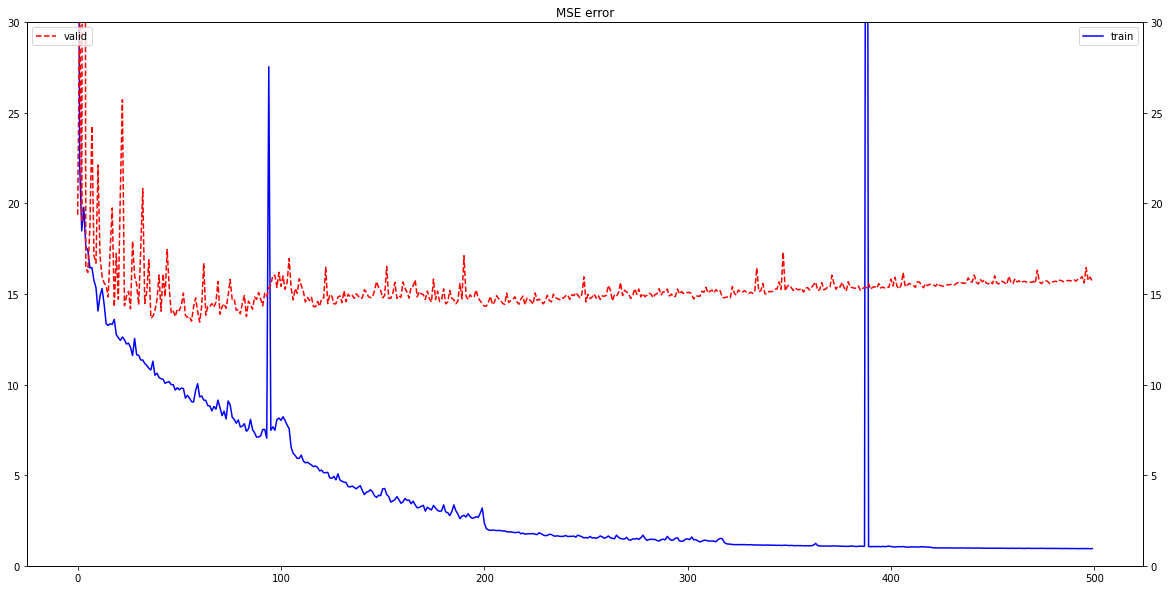

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_mse_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,30)

ax2 = ax1.twinx()
ax2.plot(valid_mse_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,30)

ax1.set_title('MSE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()


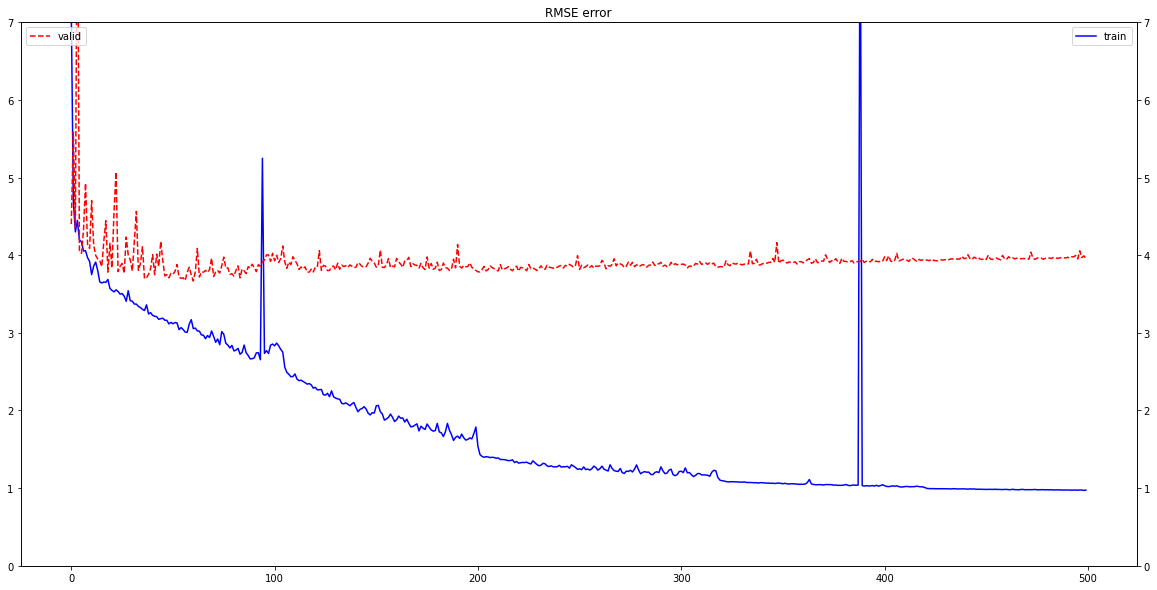

In [19]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_rmse_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,7)
ax2 = ax1.twinx()
ax2.plot(valid_rmse_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,7)
ax1.set_title('RMSE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

# Predict Train

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    train_pred = batch[0]
predict_zloc = model(train_pred.reshape(-1,1,input_dim).to(device))

In [21]:
df_train['predict'] = predict_zloc.cpu().detach().numpy()
df_train[['zloc','predict']].head(10)

,zloc,predict
0,8.41,8.293418
1,58.49,58.325680
2,34.38,34.295490
3,13.22,13.232427
4,38.26,38.895786
5,51.17,51.228741
6,23.02,23.112610
7,48.22,48.177288
8,31.73,31.475208
9,19.72,19.530210


In [22]:
import numpy as np
abs0 = np.abs(df_train.zloc-df_train.predict)
abs0

0        0.116582
1        0.164320
2        0.084510
3        0.012427
4        0.635786
           ...   
22017    0.046696
22018    0.144038
22019    0.257161
22020    0.974914
22021    0.049277
Length: 22022, dtype: float64

In [23]:
sum(abs0/len(df_train))

0.2738130705142891

# Predict Test

In [24]:
# 가중치 가져오기
model = Zloc_Estimaotor(input_dim, hidden_dim,layer_dim)
model.load_state_dict(torch.load('./weights/ODD_LSTM_512_Hsw.pth'))
model.eval()
model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(14, 512, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Hardswish()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Hardswish()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Hardswish()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [25]:
test_mse, test_rmse = evaluate(model, test_dataloader)
print('Test MSE: {:4f} \t Test RMSE: {:4f}'.format(test_mse, test_rmse))

Test MSE: 15.408349 	 Test RMSE: 3.925347


In [26]:
# look dataset
for idx, batch in enumerate(test_dataloader):
    if idx == 1:
        break
    test_pred = batch[0]
predict_zloc = model(test_pred.reshape(-1,1,input_dim).to(device))

In [27]:
df_test['predict'] = predict_zloc.cpu().detach().numpy()
df_test[['zloc','predict']].head(10)

,zloc,predict
0,44.91,40.591579
1,33.82,33.741894
2,3.98,6.204111
3,11.39,13.591003
4,13.04,13.441332
5,21.00,19.946676
6,21.09,20.534128
7,48.50,48.688763
8,22.45,22.787661
9,51.44,50.998943


In [28]:
import numpy as np
abs0 = np.abs(df_test.zloc-df_test.predict)
abs0

0        4.318421
1        0.078106
2        2.224111
3        2.201003
4        0.401332
          ...    
4714     1.520321
4715     2.290079
4716     1.826078
4717     1.316422
4718    16.246003
Length: 4719, dtype: float64

In [29]:
sum(abs0/len(df_test))

2.087372659827521

# Visualization